In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

In [19]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4681294110344157822
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3643801600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2864206526450763927
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [20]:
# MAX_VNUM = 20000
SEQUENCE_LENGTH = 300
EMBED_DIMENSION = 100
BATCH_SIZE = 64
K_FOLD = 5
NUM_HEADS = 4
FF_DIMENSION = 32

In [21]:
isot_column_names = ["lemmatized_clean_text", "labels"]
isot_data = pd.read_csv("../Data_Preprocessing/Preprocessed_Dataset/ISOT_Preprocessed_Data.csv", encoding='utf-8', encoding_errors='ignore')[isot_column_names]
isot_train, isot_test = train_test_split(isot_data, test_size=0.2)

fnc_column_names = ["lemmatized_clean_final_article", "labels"]
fnc_data = pd.read_csv("../Preprocessed_Dataset/fnc1_Preprocessed_Data.csv", encoding='utf-8', encoding_errors='ignore')[fnc_column_names]
fnc_train, fnc_test = train_test_split(fnc_data, test_size=0.2)

column_names = ["text", "labels"]
train = pd.concat([
    isot_train.rename(columns={isot_column_names[0]: column_names[0], isot_column_names[1]: column_names[1]}),
    fnc_train.rename(columns={fnc_column_names[0]: column_names[0], fnc_column_names[1]: column_names[1]}),
    fnc_train.rename(columns={fnc_column_names[0]: column_names[0], fnc_column_names[1]: column_names[1]}),
    fnc_train.rename(columns={fnc_column_names[0]: column_names[0], fnc_column_names[1]: column_names[1]})
])

In [22]:
token = keras.preprocessing.text.Tokenizer()
token.fit_on_texts(isot_data[isot_column_names[0]])
token.fit_on_texts(fnc_data[fnc_column_names[0]])
vocab_size = len(token.word_index) + 2

In [23]:
embedding_vector = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in tqdm(f):
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embedding_vector[word] = coefs
embedding_matrix = np.zeros((vocab_size, EMBED_DIMENSION))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:09, 44247.04it/s]
100%|██████████| 134334/134334 [00:00<00:00, 1830918.27it/s]


### Model

In [24]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads !=0:
             raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
    
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b = True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights
    
    def seperate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm = [0, 2, 1, 3])
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        query = self.seperate_heads(query, batch_size)
        key = self.seperate_heads(key, batch_size)
        value = self.seperate_heads(value, batch_size)
        
        attention, weights = self.attention(query, key, value)
        
        attention = tf.transpose(attention, perm=[0,2,1,3])
        
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        
        output = self.combine_heads(concat_attention)
        
        return output

In [25]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embedding = layers.Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            input_length=SEQUENCE_LENGTH,
            trainable=False  # Set to False to keep the pre-trained embeddings fixed
        )
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training = training)
        
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        
        fnn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

In [26]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim = vocab_size, output_dim = embed_dim)
        self.pos_emb = layers.Embedding(input_dim = maxlen, output_dim = embed_dim)
    
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit = maxlen, delta=1)
        positions = self.pos_emb(positions)
        
        x = self.token_emb(x)
        
        return x + positions

In [27]:

def model_generator():
    inputs = layers.Input(shape = (SEQUENCE_LENGTH,))
    embedding_layer = TokenAndPositionEmbedding(SEQUENCE_LENGTH, vocab_size, EMBED_DIMENSION)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(EMBED_DIMENSION, NUM_HEADS, FF_DIMENSION)

    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(10, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs = inputs, outputs = outputs)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    return model

In [28]:
train_x = token.texts_to_sequences(train[column_names[0]])
train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
train_y = train[column_names[1]]
# validation_x = token.texts_to_sequences(fnc_train[fnc_column_names[0]])
# validation_x = keras.preprocessing.sequence.pad_sequences(validation_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
# validation_y = fnc_train[fnc_column_names[1]]


In [29]:
epochs = 5
model = model_generator()
history = model.fit(x=train_x, y=train_y, validation_split=0.2,
                                               epochs=epochs, batch_size=BATCH_SIZE)

Epoch 1/5
585/585 [==============================] - 19s 30ms/step - loss: 0.0994 - accuracy: 0.9616 - precision_1: 0.9564 - recall_1: 0.9658 - val_loss: 0.4802 - val_accuracy: 0.8049 - val_precision_1: 0.8788 - val_recall_1: 0.8814
Epoch 2/5
585/585 [==============================] - 17s 29ms/step - loss: 0.0204 - accuracy: 0.9925 - precision_1: 0.9912 - recall_1: 0.9936 - val_loss: 0.4049 - val_accuracy: 0.8305 - val_precision_1: 0.8773 - val_recall_1: 0.9201
Epoch 3/5
585/585 [==============================] - 17s 29ms/step - loss: 0.0137 - accuracy: 0.9943 - precision_1: 0.9927 - recall_1: 0.9956 - val_loss: 0.4199 - val_accuracy: 0.8333 - val_precision_1: 0.8820 - val_recall_1: 0.9176
Epoch 4/5
585/585 [==============================] - 17s 29ms/step - loss: 0.0121 - accuracy: 0.9947 - precision_1: 0.9942 - recall_1: 0.9950 - val_loss: 0.6762 - val_accuracy: 0.7678 - val_precision_1: 0.9390 - val_recall_1: 0.7638
Epoch 5/5
585/585 [==============================] - 17s 29ms/step -

In [30]:
isot_test_x = token.texts_to_sequences(isot_test[isot_column_names[0]])
isot_test_x = keras.preprocessing.sequence.pad_sequences(isot_test_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
isot_test_y = isot_test[isot_column_names[1]]
fnc_test_x = token.texts_to_sequences(fnc_test[fnc_column_names[0]])
fnc_test_x = keras.preprocessing.sequence.pad_sequences(fnc_test_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
fnc_test_y = fnc_test[fnc_column_names[1]]

isot_loss, isot_accuracy, isot_precision, isot_recall = model.evaluate(x=isot_test_x, y=isot_test_y)
fnc_loss, fnc_accuracy, fnc_precision, fnc_recall = model.evaluate(x=fnc_test_x, y=fnc_test_y)

29/29 [==============================] - 0s 7ms/step - loss: 0.7537 - accuracy: 0.8108 - precision_1: 0.8395 - recall_1: 0.9515


In [36]:
isot_f1 = 2 * (isot_precision * isot_recall) / (isot_precision + isot_recall)
fnc_f1 = 2 * (fnc_precision * fnc_recall) / (fnc_precision + fnc_recall)
print("ISOT F1: {}, FNC F1: {}".format(isot_f1, fnc_f1))

ISOT F1: 0.9888811810260575, FNC F1: 0.8919772621028456


In [31]:
from matplotlib import pyplot as plt

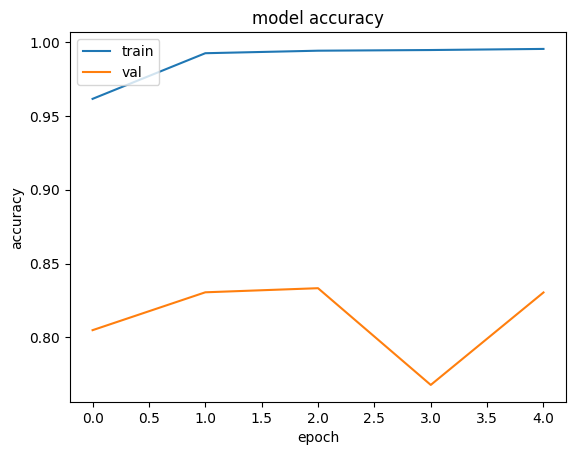

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

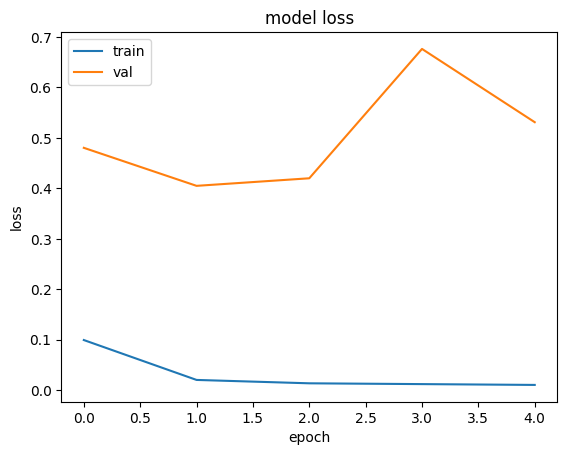

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
model.save("Transformer_ISOT+FNC")

INFO:tensorflow:Assets written to: Transformer_ISOT+FNC\assets


INFO:tensorflow:Assets written to: Transformer_ISOT+FNC\assets


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = [{'Loss': round(np.average(loss), 3), 'Accuracy': round(np.average(accuracy), 3), 'Precision': round(np.average(precision), 3),
         'Recall': round(np.average(recall), 3), 'F1 Score': round(np.average(F1), 3)},
        ]
df = pd.DataFrame(data)


In [ ]:
dir = os.getcwd()
print(dir)

In [ ]:
change_dir = os.path.dirname(dir)
subdir = "results"
dir_path = os.path.join(change_dir, subdir)
print(dir_path)

In [ ]:
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    print(f"Created directory {dir_path}")
else:
    print(f"Directory {dir_path} already exists")

In [ ]:
# Create a figure and plot the DataFrame as a table
fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)

# Save the figure as a PNG image
plt.savefig('../results/transformer_isot_3fnc_result.png')

### Generalization

In [33]:
fakes_column_names = ["lemmatized_clean_final_article", "labels"]
fakes_data = pd.read_csv("../Preprocessed_Dataset/Fakes_Preprocessed_Data.csv", encoding='utf-8', encoding_errors='ignore')[fakes_column_names]

fakes_x = token.texts_to_sequences(fakes_data[fakes_column_names[0]])
fakes_x = keras.preprocessing.sequence.pad_sequences(fakes_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
fakes_y = fakes_data[fakes_column_names[1]]

fakes_loss, fakes_accuracy, fakes_precision, fakes_recall = model.evaluate(x=fakes_x, y=fakes_y)
fakes_F1 = 2 * (fakes_precision * fakes_recall) / (fakes_precision + fakes_recall)
print("FAKES Loss: {}, FAKES Accuracy: {}, FAKES Precision: {}, FAKES Recall: {}, FAKES F1: {}".format(fakes_loss, fakes_accuracy, fakes_precision, fakes_recall, fakes_F1))

26/26 [==============================] - 0s 15ms/step - loss: 3.7762 - accuracy: 0.5211 - precision_1: 0.5298 - recall_1: 0.8568
FAKES Loss: 3.776207447052002, FAKES Accuracy: 0.5211442708969116, FAKES Precision: 0.5297532677650452, FAKES Recall: 0.8568075299263, FAKES F1: 0.6547085271412579
